In [ ]:
!pip install opencv-python

In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


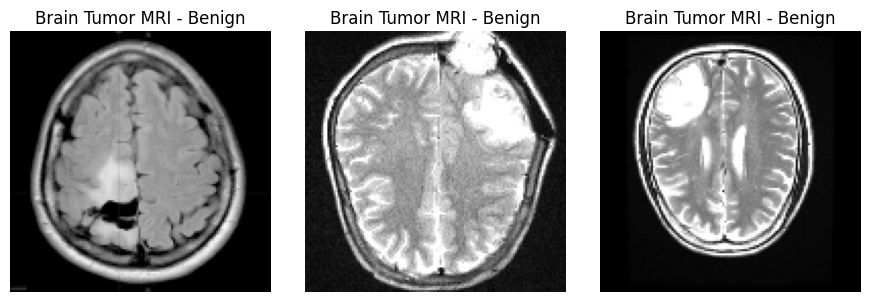

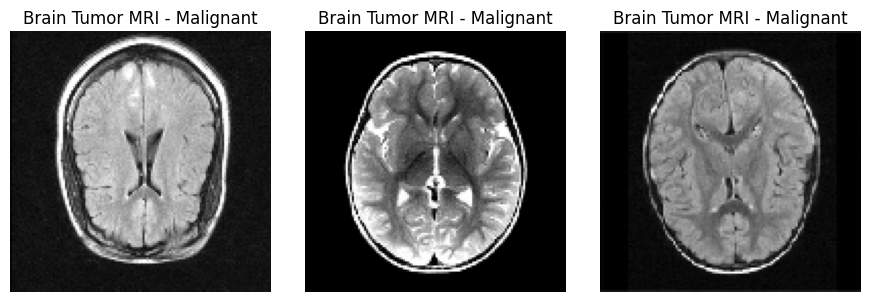

In [ ]:
# Dataset 1 Paths (Benign and Malignant)
dataset1_benign = '/content/drive/MyDrive/brain_mri/Brain_Tumor_Detection/yes'
dataset1_malignant = '/content/drive/MyDrive/brain_mri/Brain_Tumor_Detection/no'

# Import necessary libraries
import matplotlib.pyplot as plt
import os
import cv2

# Function to load and display sample images
def show_sample_images(folder, label, dataset_name, num_images=3):
    images_shown = 0
    plt.figure(figsize=(num_images * 3, 3))
    for i, filename in enumerate(os.listdir(folder)):
        if images_shown >= num_images:
            break
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            plt.subplot(1, num_images, images_shown + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"{dataset_name} - {label}")
            plt.axis('off')
            images_shown += 1
    plt.tight_layout()
    plt.show()

# Display sample images for Dataset 1
show_sample_images(dataset1_benign, "Benign", "Brain Tumor MRI")
show_sample_images(dataset1_malignant, "Malignant", "Brain Tumor MRI")

In [ ]:
# Load Dataset 1 Images and Normalize
def load_and_normalize_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img = img.astype('float32') / 255.0  # Normalize to [0, 1]
            images.append(img)
    return images

# Load and normalize the images for Dataset 1
images1_benign = load_and_normalize_images(dataset1_benign)  # Load benign images
images1_malignant = load_and_normalize_images(dataset1_malignant)  # Load malignant images

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Prepare Data
X1 = np.array(images1_benign + images1_malignant).reshape(-1, 128, 128, 1)
y1 = ['benign'] * len(images1_benign) + ['malignant'] * len(images1_malignant)

# Encode and preprocess labels
le = LabelEncoder()
y1_encoded = le.fit_transform(y1)
y1_categorical = to_categorical(y1_encoded)

# Train-Test Split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1_categorical, test_size=0.2, random_state=42, stratify=y1_categorical)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

def create_regularized_cnn_model(input_shape=(128, 128, 1)):
    model = Sequential()

    # Downsampling with BatchNormalization and Dropout
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))  # Added dropout

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))  # Added dropout

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))  # Stronger dropout

    # Upsampling
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    # Dense classification head
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Final dropout before output
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=1e-4),  # Slower learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create and view summary
model = create_regularized_cnn_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             

 Total params: 33,745,714 (128.73 MB)

 Trainable params: 33,745,042 (128.73 MB)

 Non-trainable params: 672 (2.62 KB)

In [ ]:


# Train the model on Dataset 1
history1 = model.fit(
    X_train1, y_train1,
    epochs=20,
    batch_size=32,
    validation_data=(X_test1, y_test1)
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.7005 - loss: 1.0810 - val_accuracy: 0.5533 - val_loss: 0.6671
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - accuracy: 0.8119 - loss: 0.4310 - val_accuracy: 0.7867 - val_loss: 0.6201
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8529 - loss: 0.3498 - val_accuracy: 0.8150 - val_loss: 0.5601
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8813 - loss: 0.2794 - val_accuracy: 0.5317 - val_loss: 0.9597
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8839 - loss: 0.2850 - val_accuracy: 0.7433 - val_loss: 0.6979
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9191 - loss: 0.1975 - val_accuracy: 0.8450 - val_loss: 0.3611
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9329 - loss: 0.1837 - val_accuracy: 0.8450 - val_loss: 0.3894
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9484 - loss: 0.1482 - val_accuracy: 0.8850 

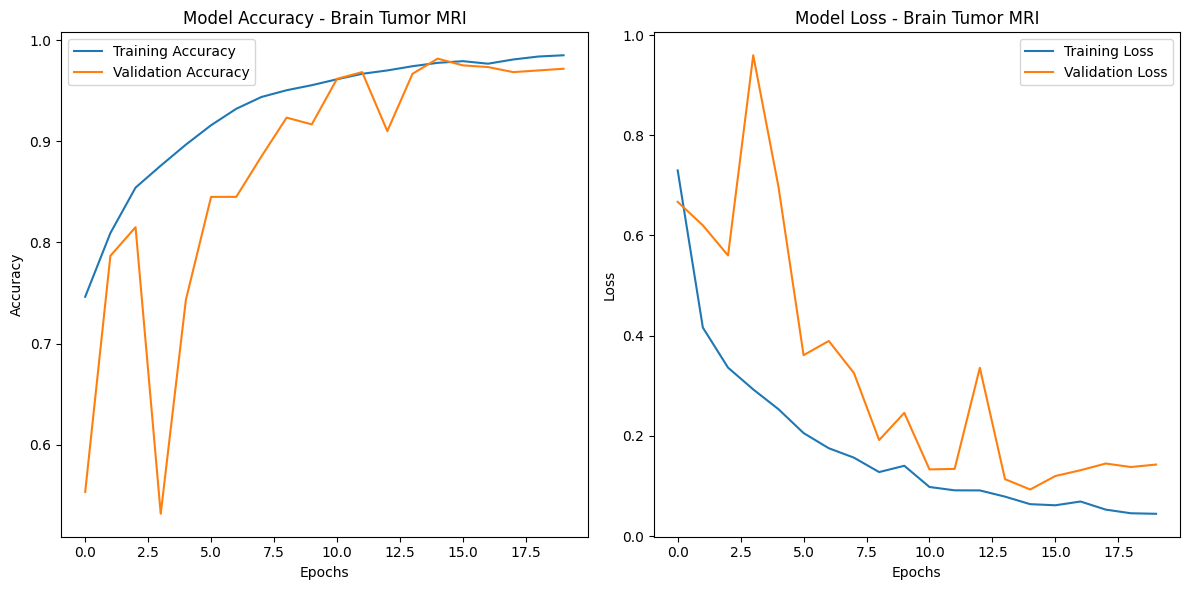

In [ ]:
# Plotting the accuracy and loss for Dataset 1
plt.figure(figsize=(12, 6))

# Accuracy Graph for Dataset 1
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy - Brain Tumor MRI')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Graph for Dataset 1
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - Brain Tumor MRI')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Evaluate the model on Dataset 1
y_pred1 = model.predict(X_test1)
y_pred1_classes = np.argmax(y_pred1, axis=1)  # Convert to class labels (0 or 1)

y_true1 = np.argmax(y_test1, axis=1)  # Ground truth labels (0 or 1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


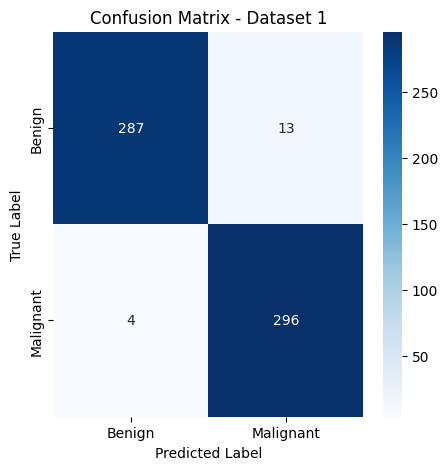

In [ ]:
# Confusion Matrix for Dataset 1
cm1 = confusion_matrix(y_true1, y_pred1_classes)
plot_confusion_matrix(cm1, classes=['Benign', 'Malignant'], title='Confusion Matrix - Dataset 1')

In [ ]:
# Classification Report for Dataset 2
print("Classification Report - Dataset 1")
print(classification_report(y_true1, y_pred1_classes, target_names=['Benign', 'Malignant']))


Classification Report - Dataset 1
              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97       300
   Malignant       0.96      0.99      0.97       300

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



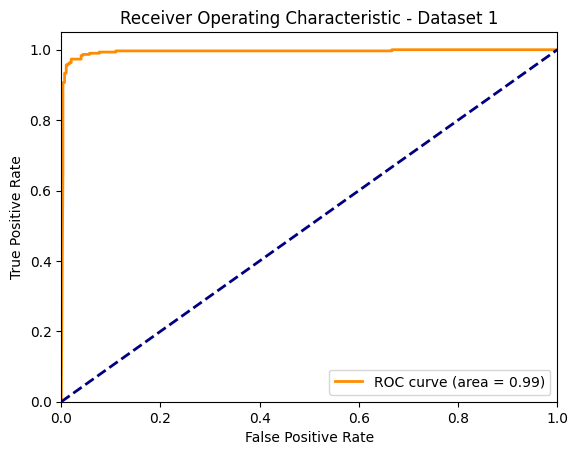

In [ ]:

# ROC Curve for Dataset 1
fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_pred1[:, 1])  # Use the probabilities for class 1 (Malignant)
roc_auc1 = auc(fpr1, tpr1)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Dataset 1')
plt.legend(loc='lower right')
plt.show()